#### This notebook demonstrates the use of an optimized data pre-processing algorithm for bias mitigation

- The debiasing function used is implemented in the `OptimPreproc` class.
- Define parameters for optimized pre-processing specific to the dataset.
- Divide the dataset into training, validation, and testing partitions.
- Learn the optimized pre-processing transformation from the training data.
- Train classifier on original training data.
- Estimate the optimal classification threshold, that maximizes balanced accuracy without fairness constraints (from the original validation set).
- Determine the prediction scores for original testing data. Using the estimated optimal classification threshold, compute accuracy and fairness metrics.
- Transform the testing set using the learned probabilistic transformation.
- Determine the prediction scores for transformed testing data. Using the estimated optimal classification threshold, compute accuracy and fairness metrics.


In [1]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_adult, get_distortion_german, get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
from common_utils import compute_metrics

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

#### Load dataset and specify options

In [29]:
# import dataset
dataset_used = "german" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2

if protected_attribute_used == 1:
    privileged_groups = [{'sex': 1}]
    unprivileged_groups = [{'sex': 0}]
    dataset_orig = load_preproc_data_german(['sex'])
    optim_options = {
        "distortion_fun": get_distortion_german,
        "epsilon": 0.05,
        "clist": [0.99, 1.99, 2.99],
        "dlist": [.1, 0.05, 0]
    }

else:
    privileged_groups = [{'age': 1}]
    unprivileged_groups = [{'age': 0}]
    dataset_orig = load_preproc_data_german(['age'])
    optim_options = {
        "distortion_fun": get_distortion_german,
        "epsilon": 0.1,
        "clist": [0.99, 1.99, 2.99],
        "dlist": [.1, 0.05, 0]
    }    

#random seed
np.random.seed(1)

# Split into train, validation, and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

In [30]:
dataset_orig.convert_to_dataframe()[0]

,age,sex,credit_history=Delay,credit_history=None/Paid,credit_history=Other,savings=500+,savings=<500,savings=Unknown/None,employment=1-4 years,employment=4+ years,employment=Unemployed,credit
0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
996,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
997,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
998,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0


#### Display dataset attributes

In [31]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(700, 11)


#### Favorable and unfavorable labels

1.0 2.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


In [32]:
dataset_orig_train.feature_names

['age',
 'sex',
 'credit_history=Delay',
 'credit_history=None/Paid',
 'credit_history=Other',
 'savings=500+',
 'savings=<500',
 'savings=Unknown/None',
 'employment=1-4 years',
 'employment=4+ years',
 'employment=Unemployed']

#### Metric for original training data

In [33]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.066728


#### Train with and transform the original training data

In [34]:
dataset_orig_train.protected_attribute_names

['sex']

In [35]:
OP = OptimPreproc(OptTools, optim_options,
                  unprivileged_groups = unprivileged_groups,
                  privileged_groups = privileged_groups)

OP = OP.fit(dataset_orig_train)

# Transform training data and align features
dataset_transf_train = OP.transform(dataset_orig_train, transform_Y=True)
dataset_transf_train = dataset_orig_train.align_datasets(dataset_transf_train)

Privileged and unprivileged groups specified will not be used. The protected attributes are directly specified in the data preprocessing function. The current implementation automatically adjusts for discrimination across all groups. This can be changed by changing the optimization code.

This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 5 times so far.


This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 6 

Optimized Preprocessing: Objective converged to 0.000000


#### Metric with the transformed training data

In [36]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.035315


Optimized preprocessing has reduced the disparity in favorable outcomes between the privileged and unprivileged
groups (training data).

In [37]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < np.abs(metric_orig_train.mean_difference())

#### Load, clean up original test data and compute metric

In [38]:
dataset_orig_test = dataset_transf_train.align_datasets(dataset_orig_test)
display(Markdown("#### Testing Dataset shape"))
print(dataset_orig_test.features.shape)

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Testing Dataset shape

(150, 11)


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.068980


#### Transform test data and compute metric

In [39]:
dataset_transf_test = OP.transform(dataset_orig_test, transform_Y = True)
dataset_transf_test = dataset_orig_test.align_datasets(dataset_transf_test)

metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_test.mean_difference())

#### Transformed test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.015886


Optimized preprocessing has reduced the disparity in favorable outcomes between the privileged and unprivileged
groups (test data).

In [40]:
### Testing 
assert np.abs(metric_transf_test.mean_difference()) < np.abs(metric_orig_test.mean_difference())

### Train classifier on original data

In [41]:
# Random Forest classifier and predictions
# scale_orig = StandardScaler()
# X_train = scale_orig.fit_transform(dataset_orig_train.features)
# y_train = dataset_orig_train.labels.ravel()
X_train = dataset_orig_train.features
y_train = dataset_orig_train.labels.ravel()

lmod = RandomForestClassifier(random_state=0)
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores original test set

In [42]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
# X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
X_valid = dataset_orig_valid_pred.features
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
# X_test = scale_orig.transform(dataset_orig_test_pred.features)
X_test = dataset_orig_test_pred.features
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Find the optimal classification threshold from the validation set

In [43]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

Best balanced accuracy (no fairness constraints) = 0.6715
Optimal classification threshold (no fairness constraints) = 0.6633


### Predictions and fairness metrics from original test set

In [44]:
display(Markdown("#### Predictions from original testing data"))

bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []
stats_par_diff_arr_orig = []
eq_opt_diff_arr_orig = []
theil_arr_orig = []

display(Markdown("#### Testing set"))
display(Markdown("##### Raw predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

    if (thresh == best_class_thresh):
        disp = True
    else:
        disp = False
        
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                       unprivileged_groups, privileged_groups, disp=disp)
    
    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    stats_par_diff_arr_orig.append(metric_test_bef["Statistical parity difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    eq_opt_diff_arr_orig.append(metric_test_bef["Equal opportunity difference"])
    theil_arr_orig.append(metric_test_bef["Theil index"])

#### Predictions from original testing data

#### Testing set

##### Raw predictions - No fairness constraints

100%|██████████| 100/100 [00:00<00:00, 1283.70it/s]

Balanced accuracy = 0.6143
Statistical parity difference = -0.0217
Disparate impact = 0.9565
Average odds difference = 0.0195
Equal opportunity difference = 0.0067
Theil index = 0.4063


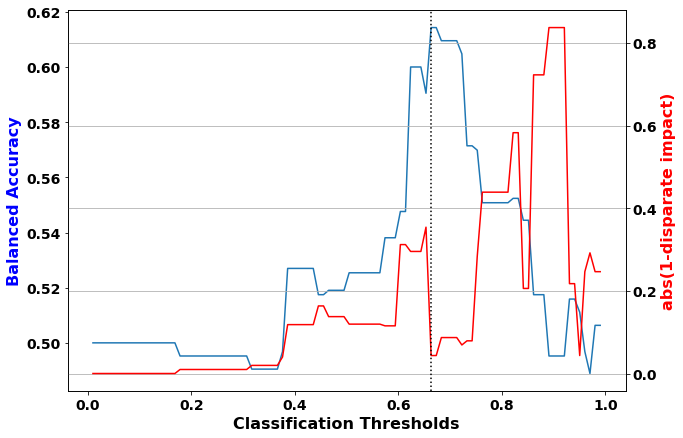

In [45]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_orig = np.abs(1.0-np.array(disp_imp_arr_orig))[best_ind]

In [46]:
best_bal_acc_orig = bal_acc_arr_orig[best_ind]
best_stats_par_diff_orig = stats_par_diff_arr_orig[best_ind]
best_disp_imp_orig = disp_imp_arr_orig[best_ind]
best_avg_odds_diff_orig = avg_odds_diff_arr_orig[best_ind]
best_eq_opt_diff_orig = eq_opt_diff_arr_orig[best_ind]
best_theil_orig = theil_arr_orig[best_ind]

In [47]:
print("Best Balanced accuracy:", best_bal_acc_orig)
print("Best Statistical parity difference:",best_stats_par_diff_orig )
print("Best Disparate impact:", best_disp_imp_orig)
print("Best Average odds difference:", best_avg_odds_diff_orig)
print("Best Equal opportunity difference:", best_eq_opt_diff_orig)
print("Best Theil index:", best_theil_orig)

Best Balanced accuracy: 0.6142857142857143
Best Statistical parity difference: -0.021739130434782594
Best Disparate impact: 0.9565217391304348
Best Average odds difference: 0.019497126436781587
Best Equal opportunity difference: 0.006666666666666599
Best Theil index: 0.4062547876805109


```abs(1-disparate impact)``` must be close to zero for classifier predictions to be fair.

### Train classifier on transformed data and obtain predictions with its fairness metrics

In [48]:
# scale_transf = StandardScaler()
# X_train = scale_transf.fit_transform(dataset_transf_train.features)
X_train = dataset_transf_train.features
y_train = dataset_transf_train.labels.ravel()

lmod = RandomForestClassifier(random_state=0)
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

dataset_transf_train_pred = dataset_transf_train.copy()
dataset_transf_train_pred.labels = y_train_pred

### Predictions and fairness metrics from transformed test set

In [49]:
dataset_transf_test_pred = dataset_transf_test.copy(deepcopy=True)
# X_test = scale_transf.transform(dataset_transf_test_pred.features)
X_test = dataset_transf_test_pred.features
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [50]:
display(Markdown("#### Predictions from transformed testing data"))

bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []
stats_par_diff_arr_transf = []
eq_opt_diff_arr_transf = []
theil_arr_transf = []

display(Markdown("#### Testing set"))
display(Markdown("##### Transformed predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label

    if (thresh == best_class_thresh):
        disp = True
    else:
        disp = False
        
    metric_test_bef = compute_metrics(dataset_transf_test, dataset_transf_test_pred, 
                                       unprivileged_groups, privileged_groups, disp=disp)
    
    bal_acc_arr_transf.append(metric_test_bef["Balanced accuracy"])
    stats_par_diff_arr_transf.append(metric_test_bef["Statistical parity difference"])
    disp_imp_arr_transf.append(metric_test_bef["Disparate impact"])
    avg_odds_diff_arr_transf.append(metric_test_bef["Average odds difference"])
    eq_opt_diff_arr_transf.append(metric_test_bef["Equal opportunity difference"])
    theil_arr_transf.append(metric_test_bef["Theil index"])

#### Predictions from transformed testing data

#### Testing set

##### Transformed predictions - No fairness constraints

  0%|          | 0/100 [00:00<?, ?it/s]

Balanced accuracy = 0.5832
Statistical parity difference = 0.1497
Disparate impact = 1.3113
Average odds difference = 0.1469
Equal opportunity difference = 0.1605
Theil index = 0.4013


100%|██████████| 100/100 [00:00<00:00, 1202.43it/s]


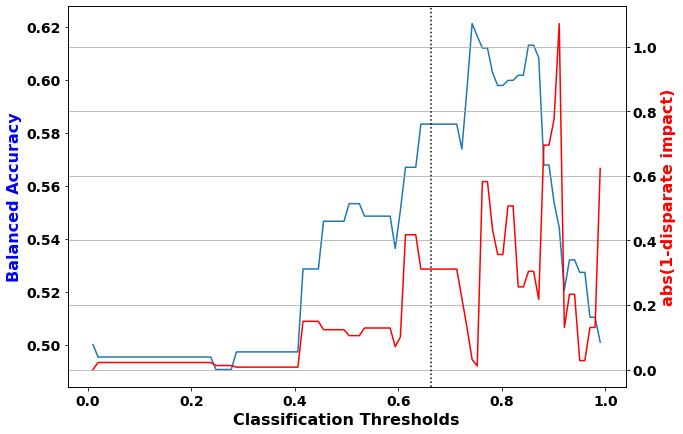

In [51]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_transf = np.abs(1.0-np.array(disp_imp_arr_transf))[best_ind]

In [52]:
best_bal_acc_transf = bal_acc_arr_transf[best_ind]
best_stats_par_diff_transf = stats_par_diff_arr_transf[best_ind]
best_disp_imp_transf = disp_imp_arr_transf[best_ind]
best_avg_odds_diff_transf = avg_odds_diff_arr_transf[best_ind]
best_eq_opt_diff_transf = eq_opt_diff_arr_transf[best_ind]
best_theil_transf = theil_arr_transf[best_ind]

In [53]:
print("Best Balanced accuracy:", best_bal_acc_transf)
print("Best Statistical parity difference:",best_stats_par_diff_transf)
print("Best Disparate impact:", best_disp_imp_transf)
print("Best Average odds difference:", best_avg_odds_diff_transf)
print("Best Equal opportunity difference:", best_eq_opt_diff_transf)
print("Best Theil index:", best_theil_transf)

Best Balanced accuracy: 0.5831903945111492
Best Statistical parity difference: 0.1496655518394649
Best Disparate impact: 1.311304347826087
Best Average odds difference: 0.1469031531531532
Best Equal opportunity difference: 0.16047297297297303
Best Theil index: 0.4013232842535784


```abs(1-disparate impact)``` must be close to zero for classifier predictions to be fair. This measure has improved using classifier trained using the transformed data compared to the original data.


In [54]:
### testing
# assert disp_imp_at_best_bal_acc_transf < disp_imp_at_best_bal_acc_orig

## Plotting

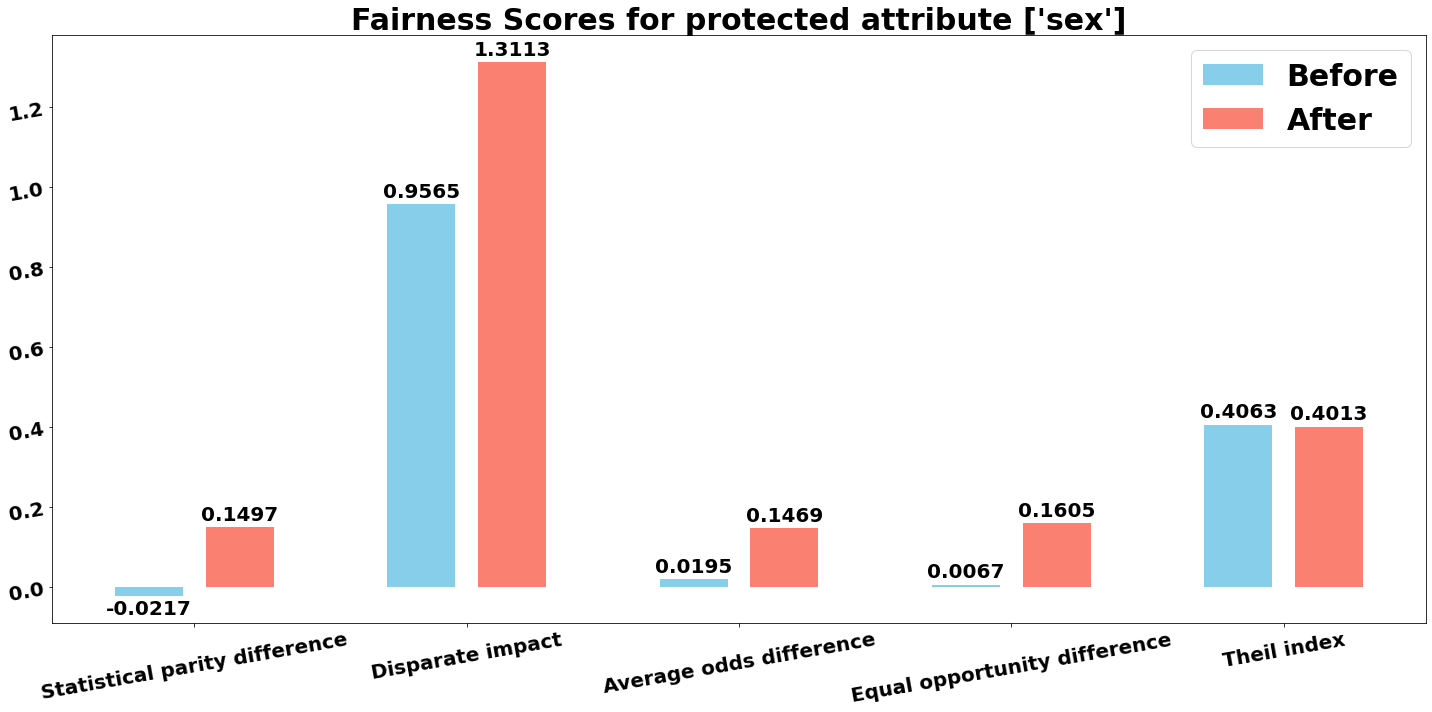

In [55]:
from matplotlib import rc
rc('font', weight='bold')
labels = ['Statistical parity difference', 'Disparate impact', 
          'Average odds difference', 'Equal opportunity difference', 'Theil index']

before = [best_stats_par_diff_orig, best_disp_imp_orig, best_avg_odds_diff_orig, 
             best_eq_opt_diff_orig, best_theil_orig]

after = [best_stats_par_diff_transf, best_disp_imp_transf, best_avg_odds_diff_transf, 
               best_eq_opt_diff_transf, best_theil_transf]

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width/3, before, width/2, label='Before', color="skyblue")
rects2 = ax.bar(x + width/3, after, width/2, label='After', color="salmon")

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores', fontdict={"size":30})
ax.set_title('Fairness Scores for protected attribute {}'.format(dataset_orig.protected_attribute_names), fontdict={"size":30,"weight":'bold'})
ax.set_xticks(x, labels, size=20, weight = 'bold')
ax.legend(fontsize=30)

ax.bar_label(rects1, padding=3, size=20, fmt="%.4f", weight = 'bold')
ax.bar_label(rects2, padding=3, size=20, fmt="%.4f", weight = 'bold')
ax.tick_params(axis='both', which='major', labelsize=20, rotation=10)

fig.tight_layout()
# plt.axis("off")
plt.show()